<a href="https://colab.research.google.com/github/DerekSHAOZH/Global_Phylogeny_by_Local_Inferences/blob/main/GPLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Configuration

In [1]:
!pip install ete3 biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.4 MB/s eta 0:00:00
  Created wheel for ete3: filename=ete3-3.1.2-py3-none-any.whl size=2273013 sha256=40ab406349eb6d7752eed1849f9583142734a7fcc454015f63be18d830ce5885
  Stored in directory: /root/.cache/pip/wheels/78/96/a0/973292c4813e6b39b611bec535521655088425516959768f46
Successfully built ete3


In [25]:
#I. Importing required packages
from re import search, compile
import math
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import copy
import os
import ete3
import random
import pandas as pd
import sys
import re
import time
from Bio import AlignIO
from Bio import Phylo
from Bio.Phylo.TreeConstruction import *
from io import StringIO

#only in google colab
from google.colab import drive
drive.mount('/content/drive')

#II. Loading the sequence dataset
# fasta_file_path = "/path/to/influenza_98.fasta" ###TODO
fasta_file_path = "/content/drive/MyDrive/WS_22_23/input_files/influenza_98.fasta" ###TODO

num_seq = 98    #TODO if change to another dataset

#III. Defining the mutation cost matrix for maximum parsimony 
W = np.array([[0, 1, 1, 1], 
              [1, 0, 1, 1],
              [1, 1, 0, 1],
              [1, 1, 1, 0]])


#IV. Setting the threshold for inferring local tree
threshold = 10  #TODO

#V. Setting the random seed for reproducibility
random.seed(1234)

#VI. Defining file name
#for example, files with prefix "98_10" means running with influenza_98 dataset at threshold 10
fn = str(num_seq) + '_' + str(threshold)

#VII. Printing messages to a log file
#not used in .ipynb
# orig_stdout = sys.stdout
# log_fn = fn + '.log'
# sys.stdout = open(log_fn, 'w')
# sys.stdout = orig_stdout

#VIII. Creating a data frame storing stats per iteration
df = pd.DataFrame(columns=['k', 'MP score of local', 'MST nodes', "Global tree vertices", "Global tree edges", "V size"])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Tree

In [26]:
#I. Importing the Tree Class for phylogeny inference
class Vertex:
  def __init__(self,name): 
    self.name = name
    self.in_degree = 0
    self.out_degree = 0
    self.parent = self
    self.children = []
    self.neighbors = []
    self.newick_label = ""
    self.sequence = ""
    self.min_cost_subtree = []
    self.is_leaf = False
    self.is_root = False
    self.subtree = []

class Tree:
  def __init__(self,name):
    self.name = name
    self.vertex_map = {}
    self.pre_order_list = []
    self.post_order_list = []
    self.edge_list_map = {}
    self.root = -1
    self.mut_cost_matrix = np.array([[0, 1, 1, 1], 
                                 [1, 0, 1, 1],
                                 [1, 1, 0, 1],
                                 [1, 1, 1, 0]]) 
    self.total_parsimony_score = 0
    self.DNA_ind_map = {"A":0,"T":1,"G":2,"C":3}
    self.DNA_list = "ATGC"
    self.max_penalty = float("inf")    
    self.first_pos_of_unique_site_pattern_to_pos_list = {}
    self.leaves = []
    self.sequence_length = 0
  def Add_mut_cost_matrix(self,W):
    self.mut_cost_matrix = W  
  def Add_vertex(self,name):    
    v = Vertex(name)
    self.vertex_map[name] = v  
  def Contains_vertex(self,name):
    return (name in self.vertex_map.keys())
  def Get_vertex(self,name):
    if name in self.vertex_map.keys():
      return (self.vertex_map[name])

  def Add_edge(self, end1_name, end2_name, distance):   #FOR PROJECT
    if end1_name not in self.vertex_map.keys():
      self.Add_vertex(end1_name)
    if end2_name not in self.vertex_map.keys():
      self.Add_vertex(end2_name)
    node1 = self.Get_vertex(end1_name)
    node2 = self.Get_vertex(end2_name) 
    node1.in_degree += 1
    node2.in_degree += 1  
    node1.neighbors.append(node2)
    node2.neighbors.append(node1)
    self.edge_list_map[(node1,node2)] = distance

  def Add_directed_edge(self, parent_name, child_name, distance):   
    if parent_name not in self.vertex_map.keys():
      self.Add_vertex(parent_name)
    if child_name not in self.vertex_map.keys():
      self.Add_vertex(child_name)
    p = self.Get_vertex(parent_name)
    c = self.Get_vertex(child_name)    
    p.out_degree += 1
    c.in_degree += 1
    c.parent = p
    p.children.append(c)
    self.edge_list_map[(p,c)] = distance
  def Get_edge_length(self, parent, child):
    if (parent, child) in self.edge_list_map.keys():
      return (self.edge_list_map[(parent, child)])
    else:
      return (self.edge_list_map[(parent, child)])
  def Set_root(self):
    for vertex in self.vertex_map.values():
      if vertex.in_degree == 0:
        self.root = vertex
        self.root.is_root = True
      else:
        vertex.is_root = False
  def Get_root(self):
    if self.root == -1:
      self.Set_root()
    return (self.root)

  def Set_MST_leaf_flags(self):   #FOR PROJECT
    for v in self.vertex_map.values():
      if len(v.neighbors) == 1:
        v.is_leaf = True
      else:
        v.is_leaf = False
        
  def Set_leaf_flags(self):
    for v in self.vertex_map.values():
      if v.out_degree == 0:
        v.is_leaf = True
      else:
        v.is_leaf = False
  def Set_leaves(self):
    self.leaves = []
    for v in self.vertex_map.values():      
      if v.is_leaf:
        self.leaves.append(v)    
  def Set_pre_order_and_post_order(self):
    self.Set_root()
    self.Set_leaf_flags()
    self.Set_leaves()
    self.pre_order_list = [self.root]
    self.post_order_list = [self.root]
    vertices_to_visit = [self.root]
    while len(vertices_to_visit) > 0:
      v = vertices_to_visit.pop()
      vertices_to_visit += v.children      
      self.post_order_list = v.children + self.post_order_list
      self.pre_order_list = self.pre_order_list + v.children
  def Compute_newick_format(self):
    if len(self.post_order_list) != len(self.vertex_map):
      self.Set_pre_order_and_post_order()
    for v in self.post_order_list:
      if v.out_degree == 0:
        v.newick_label = v.name
      else:        
        c_l = v.children[0]
        c_r = v.children[1]        
        # len_l = self.Get_edge_length(v,c_l)
        # len_r = self.Get_edge_length(v,c_r)
        # v.newick_label = f'({c_l.newick_label}:{len_l},{c_r.newick_label}:{len_r})'
        v.newick_label = f'({c_l.newick_label},{c_r.newick_label})'
    self.root.newick_label += ";"
    return(self.root.newick_label)   

  ################################################
  # Add an iteration counter to avoind duplicated names for hidden vertices
  #e.g., hidden_vertex_name = "h" + str(hidden_vertex_ind) + '_' + str(k)
  ################################################
  def Read_newick_string(self, newick_string, iteration_num):    
    rx = r'\([^()]+\)'
    hidden_vertex_ind = 1
    while "," in newick_string:                  
      # search for the parenthesis
      m = re.search(rx,newick_string)
      # returns a tuple containing all the subgroups of the match "()"
      string_match = m.group()            
      # remove ( and )
      siblings_string = string_match[1:-1]      
      c_left_name_and_length, c_right_name_and_length = siblings_string.split(",")
      c_left_name, c_left_length = c_left_name_and_length.split(":")
      c_right_name, c_right_length = c_right_name_and_length.split(":")
      if not self.Contains_vertex(c_left_name):
          self.Add_vertex(c_left_name)
      if not self.Contains_vertex(c_right_name):
          self.Add_vertex(c_right_name)
      hidden_vertex_name = "h" + str(hidden_vertex_ind) + '_' + str(iteration_num)
      self.Add_vertex(hidden_vertex_name)            
      self.Add_directed_edge(hidden_vertex_name, c_left_name, float(c_left_length))
      self.Add_directed_edge(hidden_vertex_name, c_right_name, float(c_right_length))
      newick_string = newick_string.replace(string_match,hidden_vertex_name)
      hidden_vertex_ind += 1 

  def Read_newick_string_without_branch_lengths(self,newick_string, iteration_num):
    rx = r'\([^()]+\)'
    hidden_vertex_ind = 1
    while "," in newick_string:                  
      # search for the parenthesis
      m = re.search(rx,newick_string)
      # returns a tuple containing all the subgroups of the match "()"
      string_match = m.group()            
      # remove ( and )
      siblings_string = string_match[1:-1]      
      c_left_name, c_right_name = siblings_string.split(",")
      # c_left_name, c_left_length = c_left_name_and_length.split(":")
      # c_right_name, c_right_length = c_right_name_and_length.split(":")
      if not self.Contains_vertex(c_left_name):
          self.Add_vertex(c_left_name)
      if not self.Contains_vertex(c_right_name):
          self.Add_vertex(c_right_name)
      hidden_vertex_name = "h" + str(hidden_vertex_ind) + '_' + str(iteration_num)
      self.Add_vertex(hidden_vertex_name)            
      self.Add_directed_edge(hidden_vertex_name, c_left_name, 0.001)
      self.Add_directed_edge(hidden_vertex_name, c_right_name, 0.001)      
      newick_string = newick_string.replace(string_match,hidden_vertex_name)
      hidden_vertex_ind += 1 

  # def Read_newick_string(self, newick_string):    
  #   rx = r'\([^()]+\)'
  #   hidden_vertex_ind = 1
  #   while "," in newick_string:                  
  #     # search for the parenthesis
  #     m = re.search(rx,newick_string)
  #     # returns a tuple containing all the subgroups of the match "()"
  #     string_match = m.group()            
  #     # remove ( and )
  #     siblings_string = string_match[1:-1]      
  #     c_left_name_and_length, c_right_name_and_length = siblings_string.split(",")
  #     c_left_name, c_left_length = c_left_name_and_length.split(":")
  #     c_right_name, c_right_length = c_right_name_and_length.split(":")
  #     if not self.Contains_vertex(c_left_name):
  #         self.Add_vertex(c_left_name)
  #     if not self.Contains_vertex(c_right_name):
  #         self.Add_vertex(c_right_name)
  #     hidden_vertex_name = "h" + str(hidden_vertex_ind)
  #     self.Add_vertex(hidden_vertex_name)            
  #     self.Add_directed_edge(hidden_vertex_name, c_left_name, float(c_left_length))
  #     self.Add_directed_edge(hidden_vertex_name, c_right_name, float(c_right_length))
  #     newick_string = newick_string.replace(string_match,hidden_vertex_name)
  #     hidden_vertex_ind += 1 


  # def Read_newick_string_without_branch_lengths(self,newick_string):
  #   rx = r'\([^()]+\)'
  #   hidden_vertex_ind = 1
  #   while "," in newick_string:                  
  #     # search for the parenthesis
  #     m = re.search(rx,newick_string)
  #     # returns a tuple containing all the subgroups of the match "()"
  #     string_match = m.group()            
  #     # remove ( and )
  #     siblings_string = string_match[1:-1]      
  #     c_left_name, c_right_name = siblings_string.split(",")
  #     # c_left_name, c_left_length = c_left_name_and_length.split(":")
  #     # c_right_name, c_right_length = c_right_name_and_length.split(":")
  #     if not self.Contains_vertex(c_left_name):
  #         self.Add_vertex(c_left_name)
  #     if not self.Contains_vertex(c_right_name):
  #         self.Add_vertex(c_right_name)
  #     hidden_vertex_name = "h" + str(hidden_vertex_ind)
  #     self.Add_vertex(hidden_vertex_name)            
  #     self.Add_directed_edge(hidden_vertex_name, c_left_name, 0.001)
  #     self.Add_directed_edge(hidden_vertex_name, c_right_name, 0.001)      
  #     newick_string = newick_string.replace(string_match,hidden_vertex_name)
  #     hidden_vertex_ind += 1 


  def Read_fasta_file(self,fasta_file_name):
    fastaFile = open(fasta_file_name,'r')
    seq = ''
    name = ''
    sequenceAlignment={}
    for line in fastaFile:
        if line.startswith('>'):
            if seq != '':
                seq = seq.upper()
                if not self.Contains_vertex(name):
                  self.Add_vertex(name)
                v = self.Get_vertex(name)
                v.sequence = seq       
                seq = ''
            name = line.strip().split('>')[1]
        else:
            seq += line.strip()
    if not self.Contains_vertex(name):
      self.Add_vertex(name)
    v = self.Get_vertex(name)
    v.sequence = seq    
    self.sequence_length = len(seq)
    # sequenceAlignment[name] = seq
    fastaFile.close()
  def Set_null_sequences_in_ancestors(self):
    for v in self.vertex_map.values():
      if not v.is_leaf:
        v.sequence = "N"*self.sequence_length
  def Get_site_pattern(self,site):
    site_pattern = "".join([l.sequence[site] for l in self.leaves])
    return(site_pattern)
  def Store_pos_list_for_unique_site_patterns(self):
    self.Set_pre_order_and_post_order()
    self.first_pos_of_unique_site_pattern_to_pos_list = {}
    unique_site_pattern_to_first_pos = {}
    for site in range(self.sequence_length):
      site_pattern = "".join([l.sequence[site] for l in self.leaves])
      # print(f"site pattern for pos{site} is {site_pattern}")
      if site_pattern in unique_site_pattern_to_first_pos.keys():                
        first_pos = unique_site_pattern_to_first_pos[site_pattern] 
        self.first_pos_of_unique_site_pattern_to_pos_list[first_pos].append(site)
      else:
        unique_site_pattern_to_first_pos[site_pattern] = site
        self.first_pos_of_unique_site_pattern_to_pos_list[site] = [site]    
  def Is_informative(self,site_pattern):
    counts = Counter(site_pattern)
    return(sum([count > 1 for count in counts.values()])>1)
  def Get_total_number_of_informative_site_patterns(self):
    total_number_of_informative_sites = 0
    total_number_of_informative_site_patterns = 0
    for site in self.first_pos_of_unique_site_pattern_to_pos_list.keys():     
      site_pattern = "".join([l.sequence[site] for l in self.leaves])  
      if (self.Is_informative(site_pattern)):
        pattern_weight = len(self.first_pos_of_unique_site_pattern_to_pos_list[site])        
        total_number_of_informative_sites += pattern_weight
        total_number_of_informative_site_patterns += 1
    # print(f"total number of informative sites is {total_number_of_informative_sites}")
    # print(f"total number of unique informative_site_patterns is {total_number_of_informative_site_patterns}")
  def Run_Sankoff(self,site):     
    # for site in range(self.self.sequence_length):
    # Phase 1 compute minimum mutation cost for subtrees
    pattern_weight = len(self.first_pos_of_unique_site_pattern_to_pos_list[site])
    pos_list = self.first_pos_of_unique_site_pattern_to_pos_list[site]
    for parent in self.post_order_list:
      if parent.is_leaf:
        parent.min_cost_subtree = [self.max_penalty] * 4
        dna_p_ind = self.DNA_ind_map[parent.sequence[site]]
        parent.min_cost_subtree[dna_p_ind] = 0        
      else:
        parent.min_cost_subtree = [0] * 4
        for dna_p_ind in range(4):
          for child in parent.children:                        
            min_cost_from_child_subtree = self.max_penalty
            for dna_c_ind in range(4):
              min_cost_from_child_subtree = min(min_cost_from_child_subtree, self.mut_cost_matrix[dna_p_ind][dna_c_ind] + child.min_cost_subtree[dna_c_ind])          
            parent.min_cost_subtree[dna_p_ind] += min_cost_from_child_subtree            
    # Phase 2 compute ancestral sequences
    min_cost_ind = self.root.min_cost_subtree.index(min(self.root.min_cost_subtree))
    self.total_parsimony_score += self.root.min_cost_subtree[min_cost_ind] * pattern_weight    
    dna_root = self.DNA_list[min_cost_ind]
    for pos in self.first_pos_of_unique_site_pattern_to_pos_list[site]:      
      self.root.sequence = self.root.sequence[:pos] + dna_root + self.root.sequence[(pos+1):]
    for child in self.pre_order_list[1:]:
      if not child.is_leaf:
        parent = child.parent
        char_parent = parent.sequence[site]
        dna_p_ind = self.DNA_ind_map[char_parent]
        assert(char_parent != "N")
        min_cost_ind = 0
        min_cost = self.max_penalty
        for dna_c_ind in range(4):
          if self.mut_cost_matrix[dna_p_ind][dna_c_ind] + child.min_cost_subtree[dna_c_ind] < min_cost:
            min_cost = self.mut_cost_matrix[dna_p_ind][dna_c_ind] + child.min_cost_subtree[dna_c_ind]
            min_cost_ind = dna_c_ind
        dna_child = self.DNA_list[min_cost_ind]
        for pos in self.first_pos_of_unique_site_pattern_to_pos_list[site]:
          child.sequence = child.sequence[:pos] + dna_child + child.sequence[(pos+1):]    
  def Run_Sankoff_for_all_sites(self):
    self.Set_pre_order_and_post_order()
    self.Set_null_sequences_in_ancestors()
    for site in self.first_pos_of_unique_site_pattern_to_pos_list.keys():
      site_pattern = "".join([l.sequence[site] for l in self.leaves])
      self.Run_Sankoff(site)
  def Suppress_the_root(self):
    root = self.Get_root()
    self.Set_neighbors(root)
    del self.vertex_map[root.name]
    for v in self.vertex_map.values():
      v.parent = -1
      v.children = []
  def Set_neighbors(self, vertex):
    vertex.neighbors.extend(vertex.children)
    for c in vertex.children:
      if vertex.is_root:
        # c.neighbors.extend(list(set(vertex.children) - set(c)))
        c.neighbors.extend([item for item in vertex.children if item.name != c.name])
        self.Set_neighbors(c)
      else:
        c.neighbors.append(vertex)
        self.Set_neighbors(c)

  def Root_tree_along_branch(self, node1_name, node2_name):
    self.Add_vertex("root")
    self.Set_root()
    self.root.out_degree = 2
    vertices_to_visit = [self.root]
    while len(vertices_to_visit) > 0:
      v = vertices_to_visit.pop()
      if v.is_root:
        v.children = [self.Get_vertex(node1_name), self.Get_vertex(node2_name)]
        for child in v.children:
            child.parent = v

        vertices_to_visit += v.children
      elif v.name == node1_name:
        if v.is_leaf:
          v.neighbors = []
          continue
        else:
          v.children = v.neighbors
          v.children.remove(self.Get_vertex(node2_name))
          for child in v.children:
            child.parent = v
          v.neighbors = []

          vertices_to_visit += v.children
      elif v.name == node2_name:
        if v.is_leaf:
          v.neighbors = []
          continue
        else:
          v.children = v.neighbors
          v.children.remove(self.Get_vertex(node1_name))
          for child in v.children:
            child.parent = v
          v.neighbors = []

          vertices_to_visit += v.children
      else:
        if v.is_leaf:
          v.neighbors = []
          continue
        else:
          v.children = v.neighbors
          v.children.remove(v.parent)
          for child in v.children:
            child.parent = v
          v.neighbors = []

          vertices_to_visit += v.children
    self.total_parsimony_score = 0
    # for v in T.vertex_map.values():
    #   v.neighbors = []
    

  def NNI(self, node1_name, node2_name):
    T1 = copy.deepcopy(self)

    node1_subtrees = T1.Get_vertex(node1_name).neighbors
    # print([v.name for v in node1_subtrees])
    node1_subtrees.remove(T1.Get_vertex(node2_name))
    subtree_1 = node1_subtrees[0]
    subtree_2 = node1_subtrees[1]

    node2_subtrees = T1.Get_vertex(node2_name).neighbors
    node2_subtrees.remove(T1.Get_vertex(node1_name))
    subtree_3 = node2_subtrees[0]
    subtree_4 = node2_subtrees[1]
   
    T1.Get_vertex(node1_name).neighbors = [subtree_1, subtree_3, T1.Get_vertex(node2_name)]
    T1.Get_vertex(node2_name).neighbors = [subtree_4, subtree_2, T1.Get_vertex(node1_name)]
    subtree_2.neighbors.remove(T1.Get_vertex(node1_name))
    subtree_2.neighbors.append(T1.Get_vertex(node2_name))
    subtree_3.neighbors.remove(T1.Get_vertex(node2_name))
    subtree_3.neighbors.append(T1.Get_vertex(node1_name))

    T2 = copy.deepcopy(self)

    node1_subtrees = T2.Get_vertex(node1_name).neighbors
    node1_subtrees.remove(T2.Get_vertex(node2_name))
    subtree_1 = node1_subtrees[0]
    subtree_2 = node1_subtrees[1]

    node2_subtrees = T2.Get_vertex(node2_name).neighbors
    node2_subtrees.remove(T2.Get_vertex(node1_name))
    subtree_3 = node2_subtrees[0]
    subtree_4 = node2_subtrees[1]

    T2.Get_vertex(node1_name).neighbors = [subtree_1, subtree_4, T2.Get_vertex(node2_name)]
    T2.Get_vertex(node2_name).neighbors = [subtree_3, subtree_2, T2.Get_vertex(node1_name)]
    subtree_2.neighbors.remove(T2.Get_vertex(node1_name))
    subtree_2.neighbors.append(T2.Get_vertex(node2_name))
    subtree_4.neighbors.remove(T2.Get_vertex(node2_name))
    subtree_4.neighbors.append(T2.Get_vertex(node1_name))

    return T1, T2



#2. MST

In [27]:
#I. Computing pairwise Jukes-Cantor distances between sequences
def jukes_cantor_distance(sequence1, sequence2):
  # print('computing JC distance')
  nucleotide_diff_count = 0 # how many nucleotides they differ
  total_nucleotides_compared = 0.0
  bases = {'A', 'C', 'G', 'T'}
  
  for a, b in zip(sequence1, sequence2):
    if a in bases and b in bases:
      # total_nucleotides_compared += 1
      if a != b: 
        nucleotide_diff_count += 1
      
  nucleotide_diff_percentage = nucleotide_diff_count / len(sequence1)
  # diff_pct_adjusted = min(nucleotide_diff_percentage, 0.74999)
  # jukes_cantor_distance = -0.75 * math.log(1 - min((diff_pct_adjusted*(4.0/3.0)),1.0))
  jukes_cantor_distance = -0.75 * math.log(1 - (nucleotide_diff_percentage*(4.0/3.0)))
  return jukes_cantor_distance

#II. Creating a matrix of pairwise Jukes-Cantor distance
def create_distance_matrix(seq_dict):
  dist_mat_new = np.zeros((len(seq_dict), len(seq_dict)))
  
  for i in range(len(seq_dict)):
    for j in range(i+1, len(seq_dict)):
      dist_mat_new[i][j] = jukes_cantor_distance(seq_dict[list(seq_dict.keys())[i]], seq_dict[list(seq_dict.keys())[j]])
  return dist_mat_new

#III. Creating networkx-based MST with distance matrix
def create_mst_from_dist_mat(seq_dict, distance_matrix):
  seq_id_new = list(seq_dict.keys())
  G_new = nx.Graph()
  G_new.add_nodes_from(seq_id_new)
  for i in range(len(seq_id_new)):
    for j in range(i+1, len(seq_id_new)):
      G_new.add_edge(seq_id_new[i], seq_id_new[j], weight = distance_matrix[i][j])
  MST = nx.minimum_spanning_tree(G_new)
  return MST

#3. Inferring local tree

In [28]:
#I. Selecting Vs from the MST such that it induces a subtree
def find_subtree(T, threshold): # e.g. threshold = 10
  # initialize vertices_to_visit to all of the leaves
  vertices_to_visit = T.leaves
  k = 1
  while len(vertices_to_visit) > 0:
    #randomize the starting vertex
    if k == 1:
      v = vertices_to_visit.pop(random.randrange(len(vertices_to_visit)))
      # print(v.name)
    else:
      v = vertices_to_visit.pop(0)
  
    if v.is_leaf:
        v.subtree.append(v)
        if v.neighbors[0] not in vertices_to_visit:
          #randomly shuffle the neighbors
          vertices_to_visit.extend(random.sample(v.neighbors, len(v.neighbors)))
    else:
    #if v is an internal vertex, 
      #check the number of neighbors with empty subtrees
      num_neighbor_with_empty_subtree = sum([len(n.subtree) == 0 for n in v.neighbors])
      # print(num_neighbor_with_empty_subtree)

      #if only one of its neighbors has an empty(unassigned) subtree, assign the subtree at this node
      if num_neighbor_with_empty_subtree == 1:
        # print(v.name)
        v.subtree.append(v)
        #randomly shuffle the neighbors
        for n in random.sample(v.neighbors, len(v.neighbors)):
          if len(n.subtree) > 0:
            for subtree_vertex in n.subtree:
              if subtree_vertex not in v.subtree:
                v.subtree.append(subtree_vertex)
          elif n not in vertices_to_visit:
            vertices_to_visit.append(n)

      #if the number of neighbors with empty(unassigned) subtrees > 1, 
      #then queue this vertex for re-visiting after updating its neighbors
      else:
        #randomly shuffle the neighbors
        for n in random.sample(v.neighbors, len(v.neighbors)):
          if len(n.subtree) == 0 and n not in vertices_to_visit:
            vertices_to_visit.append(n)
        vertices_to_visit.append(v)
 
    if len(v.subtree) >= threshold: 
      return v.subtree

    k += 1

#II. Selecting Ve by performing BFS from the root of the induced subtree from Vs 
#input: MST tree, Vs, threshold for Ve which is consistent with Vs
#output: Ve consisting of neighboring vertices of Vs
def extra_vertices_with_bfs(MST, Vs, threshold): #function for BFS
  Ve = [] 
  visited = []  #List for visited nodes.
  queue = []     #Initialize a queue

  visited.append(Vs[0])
  queue.append(Vs[0])

  while queue:          # Creating loop to visit each node
    m = queue.pop(0) 
    
    for neighbor in random.sample(MST.Get_vertex(m.name).neighbors, len(MST.Get_vertex(m.name).neighbors)):
      if neighbor not in visited:
        visited.append(neighbor)
        queue.append(neighbor)
        if neighbor not in Ve and neighbor not in Vs: #vertices in Vs should not be in Ve
          Ve.append(neighbor)
      if len(Ve) >= threshold:
        return Ve

# #III. Finding all internal edges for NNI
# def find_internal_edge(T):
#   internal_vertex_names = [v.name for v in T.vertex_map.values() if v.is_leaf == False]
#   internal_edge_possibilities = list(itertools.combinations(internal_vertex_names,2))
#   internal_edges = [p for p in internal_edge_possibilities if T.Get_vertex(p[0]) in T.Get_vertex(p[1]).neighbors]
#   return internal_edges

# #IV. Searching for all possible tree topologies with NNI
# #input: unrooted tree
# def search_tree(tree, root_branch_node1, root_branch_node2, nni_node1, nni_node2):
#   # 1. COMPUTE A TREE
#   # root the tree at an arbitrary branch
#   tree.Root_tree_along_branch(root_branch_node1, root_branch_node2)

#   # 2. COMPUTE THE PARSIMONY SCORE (of the rooted tree)
#   tree.Run_Sankoff_for_all_sites()
#   total_parsimony_score = tree.total_parsimony_score
#   # print(f"Total parsimony score is {tree.total_parsimony_score}")

#   # 3. MODIFY TREE TOPOLOGY
#   tree.Suppress_the_root()
#   T1, T2 = tree.NNI(nni_node1, nni_node2)

#   T1.Root_tree_along_branch(nni_node1, nni_node2)
#   T2.Root_tree_along_branch(nni_node1, nni_node2)
#   T1.Run_Sankoff_for_all_sites()
#   T2.Run_Sankoff_for_all_sites()
#   T1_parsimony_score = T1.total_parsimony_score
#   T2_parsimony_score = T2.total_parsimony_score
#   # print(f"T1 parsimony score: {T1_parsimony_score}")
#   # print(f"T2 parsimony score: {T2_parsimony_score}")

#   if T1_parsimony_score < total_parsimony_score and T1_parsimony_score < T2_parsimony_score:
#     # print("changing to T1")
#     T1.Suppress_the_root()
#     return T1
#   elif T2_parsimony_score < total_parsimony_score and T2_parsimony_score < T1_parsimony_score:
#     # print("changing to T2")
#     T2.Suppress_the_root()
#     return T2
#   else:
#     # print("not changing tree topology")
#     return tree   


#V. Converting sequence dictionary to alignment object
def convert_seq_to_aln(V, sequences, mapping):

  sequences_sub = {mapping[k]: sequences[k] for k in [v.name for v in V]}
  count = len(sequences_sub)
  length = max(map(len, sequences_sub.values()))
  msa = f" {count} {length}\n"
  msa += '\n'.join(f"{prot_id:<10} {sequence}" for prot_id, sequence in sequences_sub.items())
  # print(msa) 
  aln = AlignIO.read(StringIO(msa), 'phylip')
  return aln

#VI. Converting MP tree object to newick format
def newick_MP_local_tree(tree, mapping):
  Phylo.write(tree, "tmp.tre", 'newick')

  with open("tmp.tre", 'r') as f:
    output = f.read()
  tmp = output[0:-1]
  t = ete3.Tree(tmp, format = 1)
  newick_str = t.write(format = 9)
  for v_name, index in mapping.items():
    newick_str = newick_str.replace(index, v_name)
    # print(newick_str)
  return newick_str

#VII. Finding the local tree with maximum parsimony score
def infer_MP_local_tree(V, sequences, iteration_counter, cost_matrix):
  #The sequence ID for Phylo Alignment object can be up to 10 characters long
  #So, create a dictionary mapping V name to some shorter indices 
  mapping = {}
  for i in range(len(V)):
    index = 'No' +str(i) +'de'
    mapping[V[i].name] = index
  # print(mapping)
  aln = convert_seq_to_aln(V, sequences, mapping)

  # final_MP_newick = ''
  # final_lowest_parsimony_score = float('inf')

  # #starting with 3 random initial tree topologies to avoid local optimum
  # k = 1
  # while k < 4:
  #random starting tree
  t = ete3.Tree()
  t.populate(len(mapping), [v for v in mapping.values()])
  newick_str = t.write(format = 3)
  # print(newick_str)
  starting_tree = Phylo.read(StringIO(newick_str), "newick")
  # print(starting_tree)
  scorer = ParsimonyScorer()
  searcher = NNITreeSearcher(scorer)
  constructor = ParsimonyTreeConstructor(searcher, starting_tree)
  MP_tree = constructor.build_tree(aln)

  # cur_lowest_parsimony_score = scorer.get_score(MP_tree, aln)
  lowest_parsimony_score = scorer.get_score(MP_tree, aln)
  MP_newick = newick_MP_local_tree(MP_tree, mapping)
  # print(MP_newick)
    # if cur_lowest_parsimony_score < final_lowest_parsimony_score:
    #   final_lowest_parsimony_score = cur_lowest_parsimony_score
    #   final_MP_newick = MP_newick

  # print(f'Best parsimony score: {final_lowest_parsimony_score}')
  print(f'Best parsimony score: {lowest_parsimony_score}')
  T = Tree('local')
  # T.Read_newick_string_without_branch_lengths(final_MP_newick, iteration_counter)
  T.Read_newick_string_without_branch_lengths(MP_newick, iteration_counter)
  for v in V:
    # print(v.name)
    T.Get_vertex(v.name).sequence = sequences[v.name]

  T.sequence_length = len(sequences[V[0].name])
  
  T.Add_mut_cost_matrix(cost_matrix)
  T.Store_pos_list_for_unique_site_patterns()
  # print(f"Total number of unique site patterns is {len(T.first_pos_of_unique_site_pattern_to_pos_list)}")
  T.Get_total_number_of_informative_site_patterns()
  T.Run_Sankoff_for_all_sites()
  # print(f"Total parsimony score is {T.total_parsimony_score}")
  T.Suppress_the_root()
  # T.total_parsimony_score = lowest_parsimony_score

  return T

# #VII. Finding the local tree with maximum parsimony score
# def infer_MP_local_tree(V, sequences, iteration_counter, cost_matrix):

#   final_lowest_parsimony_score = float('inf')
#   k = 1

#   #starting with 3 random initial tree topologies to avoid local optimum
#   while k < 4:
#     print(f'##### Infer MP local tree: interation {k} begins #####')
#     t = ete3.Tree()
#     t.populate(len(V), [v.name for v in V])
#     newick_str = t.write(format = 9)
    
    
#     T = Tree('local')
#     T.Read_newick_string_without_branch_lengths(newick_str, iteration_counter)
#     for v in V:
#       T.Get_vertex(v.name).sequence = sequences[v.name]
#       #print(T.Get_vertex(v.name).sequence)
#     T.sequence_length = len(sequences[V[0].name])
#     # for l in T.leaves:
#     #   print(l.sequence)

#     # for v in T.vertex_map.values():
#     #   print(f'vertex {v.name}: out-degree {v.out_degree}, neighbors {[n.name for n in v.neighbors]}, parent {v.parent.name}, children {[c.name for c in v.children]}')

#     T.Add_mut_cost_matrix(cost_matrix)
#     T.Store_pos_list_for_unique_site_patterns()
#     print(f"Total number of unique site patterns is {len(T.first_pos_of_unique_site_pattern_to_pos_list)}")
#     T.Get_total_number_of_informative_site_patterns()
#     T.Run_Sankoff_for_all_sites()
#     total_parsimony_score = T.total_parsimony_score
#     print(f"Total parsimony score is {T.total_parsimony_score}")
#     T.Suppress_the_root()

#     if k == 1:
#       T_final = T

#     T_lowest = T
#     cur_lowest_parsimony_score = float('inf')
#     continue_search = True

#     while(continue_search):
#       # print("one more while iteration")
#       T_new = T_lowest
#       continue_search = False
#       internal_edges = find_internal_edge(T_lowest)
      

#       for b in internal_edges:
#         # print(f'NNI branch: ({b[0]}, {b[1]})')
#         tree = search_tree(T_new, b[0], b[1], b[0], b[1])
#         if tree.total_parsimony_score < cur_lowest_parsimony_score:
#           # print("Update continue_search to TRUE")
#           cur_lowest_parsimony_score = tree.total_parsimony_score
#           T_lowest = tree
#           continue_search = True
#     print(f'For iteration {k}, best parsimony score: {cur_lowest_parsimony_score}')

#     if cur_lowest_parsimony_score < final_lowest_parsimony_score:
#       T_final = T_lowest
#       final_lowest_parsimony_score = cur_lowest_parsimony_score

#     k += 1

#   return T_final

#4. Infering global tree

In [29]:
#I. Finding the subtree induced by only Vs in the local tree
#input: local unrooted phylogeny tree, Vs
#output: dictionary with a tuple of two child nodes from Vs as key and the corresponding hidden vertex as value 
#e.g.,    A
#        / \
#       B   C
def informative_subtree(tree, Vs):
  forest = {}
  for v_tuple in itertools.combinations(Vs, 2):
    if tree.Get_vertex(v_tuple[0].name).neighbors[0] is tree.Get_vertex(v_tuple[1].name).neighbors[0]:
      forest[v_tuple] = tree.Get_vertex(v_tuple[0].name).neighbors[0]
  
  return forest

#II. Deleting paired Vs vertices and Adding the new parent vertices to V
def update_subtree_vertices(forest, V):
  V_new = V.copy()
  
  for children, parent_new in forest.items():
    if children[0] in V:
      V_new.remove(children[0])
      # print(f'removed {children[0].name} from V_new')
    if children[1] in V:
      V_new.remove(children[1])
      # print(f'removed {children[1].name} from V_new')
    V_new.append(parent_new)
    # print(f'added {parent_new.name} to V_new')
  return V_new

#III. Deleting paired Vs vertices and Adding the new parent vertices to the sequence dictionary
def update_sequences(forest, seq_dict):
  sequences_new = seq_dict.copy()
  for children, parent_new in forest.items():
    if children[0].name in seq_dict.keys():
      del sequences_new[children[0].name]
      # print(f'removed {children[0].name} from sequences_new')
    if children[1].name in seq_dict.keys():
      del sequences_new[children[1].name]
      # print(f'removed {children[1].name} from sequences_new')
    sequences_new[parent_new.name] = parent_new.sequence
    # print(f'added {parent_new.name} to sequences_new')
  return sequences_new


#IV. Updating MST
def update_mst(MST, forest, V_old, sequences_sub, dist_mat_sub):
  MST_copy = MST.copy()
  #delete all within-subgraph edge from MST
  M_sub = nx.subgraph(MST, [v.name for v in V_old])
  for edge in list(M_sub.edges):
    MST_copy.remove_edge(edge[0], edge[1])
  #delete paired $V_s$ vertices and add new parent vertices to MST
  for children, parent_new in forest.items():
      if children[0].name in MST_copy.nodes:
        MST_copy.remove_node(children[0].name)
        # print(f'removed {children[0].name} from MST')
      if children[1].name in MST_copy.nodes:
        MST_copy.remove_node(children[1].name)
        # print(f'removed {children[1].name} from MST')
      MST_copy.add_node(parent_new.name)
      # print(f'added {parent_new.name} to MST')
  #create the sub-MST of V
  MST_sub = create_mst_from_dist_mat(sequences_sub, dist_mat_sub)
  #add edges in sub-MST to MST
  for edge in list(MST_sub.edges):
    MST_copy.add_edge(edge[0], edge[1], weight = MST_sub.get_edge_data(edge[0], edge[1])['weight'])

  return MST_copy  

#V. Inferring the global phylogeny tree
def infer_global_tree(T_global, MST, sequences, cost_matrix, threshold):
  #k is an int as the iteration counter to avoid duplicated naming for hidden vertex
  k = 1
  #is_last is a boolean variable indicating whether this is the last iteration
  is_last = False
  #num_sequences is an int storing the initial number of sequences (taxons)
  num_sequences = len(MST.nodes)
  #plot_1 is a boolean variable indicating whether to plot MST when number of nodes drops to 2/3 of the initial number for the first time
  plot_1 = True
  #plot_2 is a boolean variable indicating whether to plot MST when number of nodes drops to 1/3 of the initial number for the first time
  plot_2 = True

  while len(T_global.edge_list_map) < len(T_global.vertex_map) - 1:
    print(f'#################### Infer global tree: iteration {k} begins ####################')

    #Converting networkx object to our own Tree class
    M = Tree('MST')
    for edge_tuple in MST.edges():
      M.Add_edge(edge_tuple[0], edge_tuple[1], MST.get_edge_data(edge_tuple[0], edge_tuple[1])['weight'])
    M.Set_MST_leaf_flags()
    M.Set_leaves()
    for vertex_name in M.vertex_map.keys():
      M.Get_vertex(vertex_name).subtree = []

    #if number of vertices in MST is smaller than threshold,
    if len(M.vertex_map) <= threshold:
      #then all vertices will be used to constitute the last local tree
      V = [i for i in M.vertex_map.values()]
      is_last = True
    
    else:
      #Selecting Vs from the MST such that it induces a subtree
      print('Finding Vs ...')
      Vs = find_subtree(M, threshold)

      #if |Vm| - |Vs| > threshold,
      if(len(M.vertex_map) - len(Vs) > threshold):
        #Selecting Ve by performing BFS from the root of the induced subtree from Vs
        print('Finding Ve ...')
        Ve = extra_vertices_with_bfs(M, Vs, threshold)
          
        V = Vs + Ve
      else:
        V = [i for i in M.vertex_map.values()]
        is_last = True
    
    print('Inferring MP local tree ...')
    T_lowest = infer_MP_local_tree(V, sequences, k, cost_matrix)

    #if this is the last iteration, 
    if is_last:
      #add all edges in the local tree to the global tree
      vertices_visited = []
      for v_name, v in T_lowest.vertex_map.items():
        vertices_visited.append(v_name)
        for neighbor in v.neighbors:
          if(neighbor.name not in vertices_visited):
            T_global.Add_edge(v_name, neighbor.name, 0.1)
            print(f'Updating global tree: Added edge from {v_name} to {neighbor.name}, distance = 0.1')
        if T_global.Get_vertex(v_name).sequence != '':
          T_global.Get_vertex(v_name).sequence = v.sequence
      
    else: 
      #Finding the subtree induced by only Vs in the local tree
      forest = informative_subtree(T_lowest, Vs)
      # print(f'Forest: {len(forest)}')

      #if forest is not empty, 
      if (len(forest) > 0):

        #Updating the global phylogeny tree
        print('Updating global tree ...')
        for children, parent_new in forest.items():
          T_global.Add_edge(children[0].name, parent_new.name, 0.1)
          T_global.Add_edge(children[1].name, parent_new.name, 0.1)
          print(f'Updating global tree: Added edge from {children[0].name} to {parent_new.name}, distance = 0.1')
          print(f'Updating global tree: Added edge from {children[1].name} to {parent_new.name}, distance = 0.1')
          T_global.Get_vertex(parent_new.name).sequence = parent_new.sequence


        #Deleting paired Vs vertices and Adding the new parent vertices to V
        V_new = update_subtree_vertices(forest, V)

        #Deleting paired Vs vertices and Adding the new parent vertices to the sequence dictionary
        sequences = update_sequences(forest, sequences)
        
        #Updating the subgraph distance matrix of V_new
        sequences_sub = {k: sequences[k] for k in [v.name for v in V_new]}
        dist_mat_sub = create_distance_matrix(sequences_sub)
        
        #Updating the edges in the subgraph consisting of V_new in MST
        print('Updating MST ...')
        MST = update_mst(MST, forest, V, sequences_sub, dist_mat_sub)

      print(f'Current MST has {len(MST.nodes)} nodes')
      if plot_1 and len(MST.nodes) <= (2/3)*num_sequences:
        fig, ax = plt.subplots(figsize=(30, 30))
        nx.draw(MST, with_labels=True, font_weight='bold', node_size = 500)
        plot1_fn = fn + f'.MST_{len(MST.nodes)}.png'
        fig.savefig(plot1_fn)
        plot_1 = False
      if plot_2 and len(MST.nodes) <= (1/3)*num_sequences:
        fig, ax = plt.subplots(figsize=(30, 30))
        nx.draw(MST, with_labels=True, font_weight='bold', node_size = 500)
        plot2_fn = fn + f'.MST_{len(MST.nodes)}.png'
        fig.savefig(plot2_fn)
        plot_2 = False

      print(f'Current global tree has {len(T_global.vertex_map)} vertices and {len(T_global.edge_list_map)} edges')
    
    

    df.loc[k] = [k, T_lowest.total_parsimony_score, len(MST.nodes), len(T_global.vertex_map), len(T_global.edge_list_map), len(V)]

    k += 1
  
  return T_global

def newick_global_tree(tree):
  last_iter = '_' + str(max(df['k']))
  for edge_tuple in tree.edge_list_map.keys():
    if last_iter in edge_tuple[0].name and last_iter in edge_tuple[1].name:
      branch = edge_tuple
      break

  #Add 1 to out_degree of all hidden vertices
  for v_name, v in tree.vertex_map.items():
    if 'EPI' not in v_name:
      v.out_degree = 1

  tree.Root_tree_along_branch(branch[0].name, branch[1].name)
  newick_str = tree.Compute_newick_format()
  return newick_str


#5. Main

#################### Infer global tree: iteration 1 begins ####################
Finding Vs ...
Finding Ve ...
Inferring MP local tree ...
Best parsimony score: 202
Forest: 4
Updating global tree ...
Updating global tree: Added edge from EPI_ISL_8673_1973 to h1_1, distance = 0.1
Updating global tree: Added edge from EPI_ISL_21051_1972 to h1_1, distance = 0.1
Updating global tree: Added edge from EPI_ISL_146765_1968 to h2_1, distance = 0.1
Updating global tree: Added edge from EPI_ISL_110747_1969 to h2_1, distance = 0.1
Updating global tree: Added edge from EPI_ISL_113035_1969 to h3_1, distance = 0.1
Updating global tree: Added edge from EPI_ISL_110777_1970 to h3_1, distance = 0.1
Updating global tree: Added edge from EPI_ISL_110779_1971 to h7_1, distance = 0.1
Updating global tree: Added edge from EPI_ISL_8676_1972 to h7_1, distance = 0.1
Updating MST ...
Current MST has 94 nodes
Current global tree has 102 vertices and 8 edges
#################### Infer global tree: iteration 2 begins 

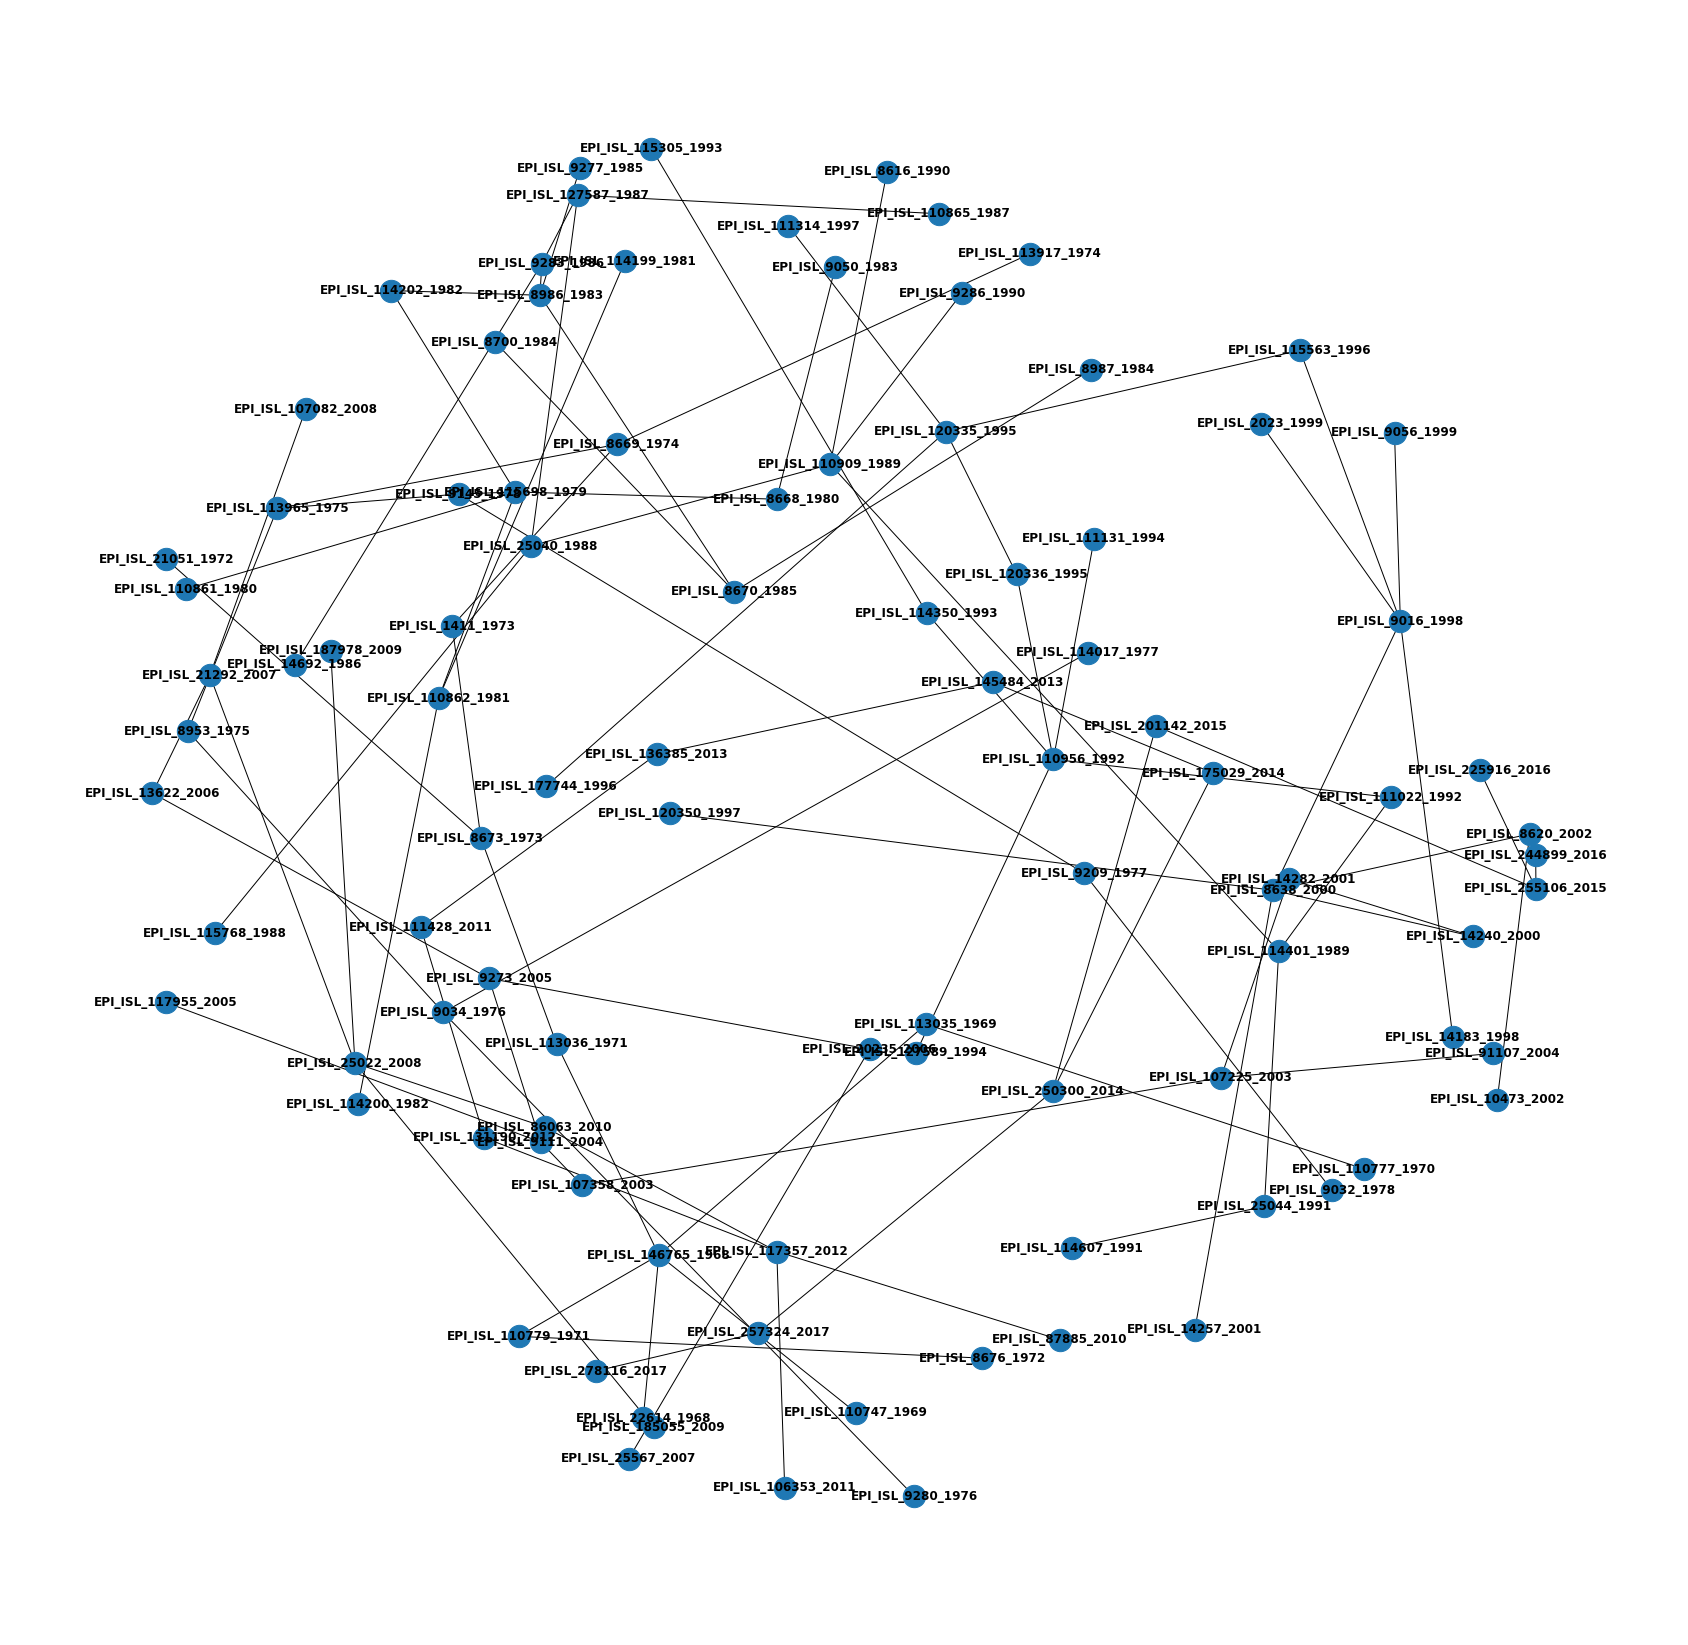

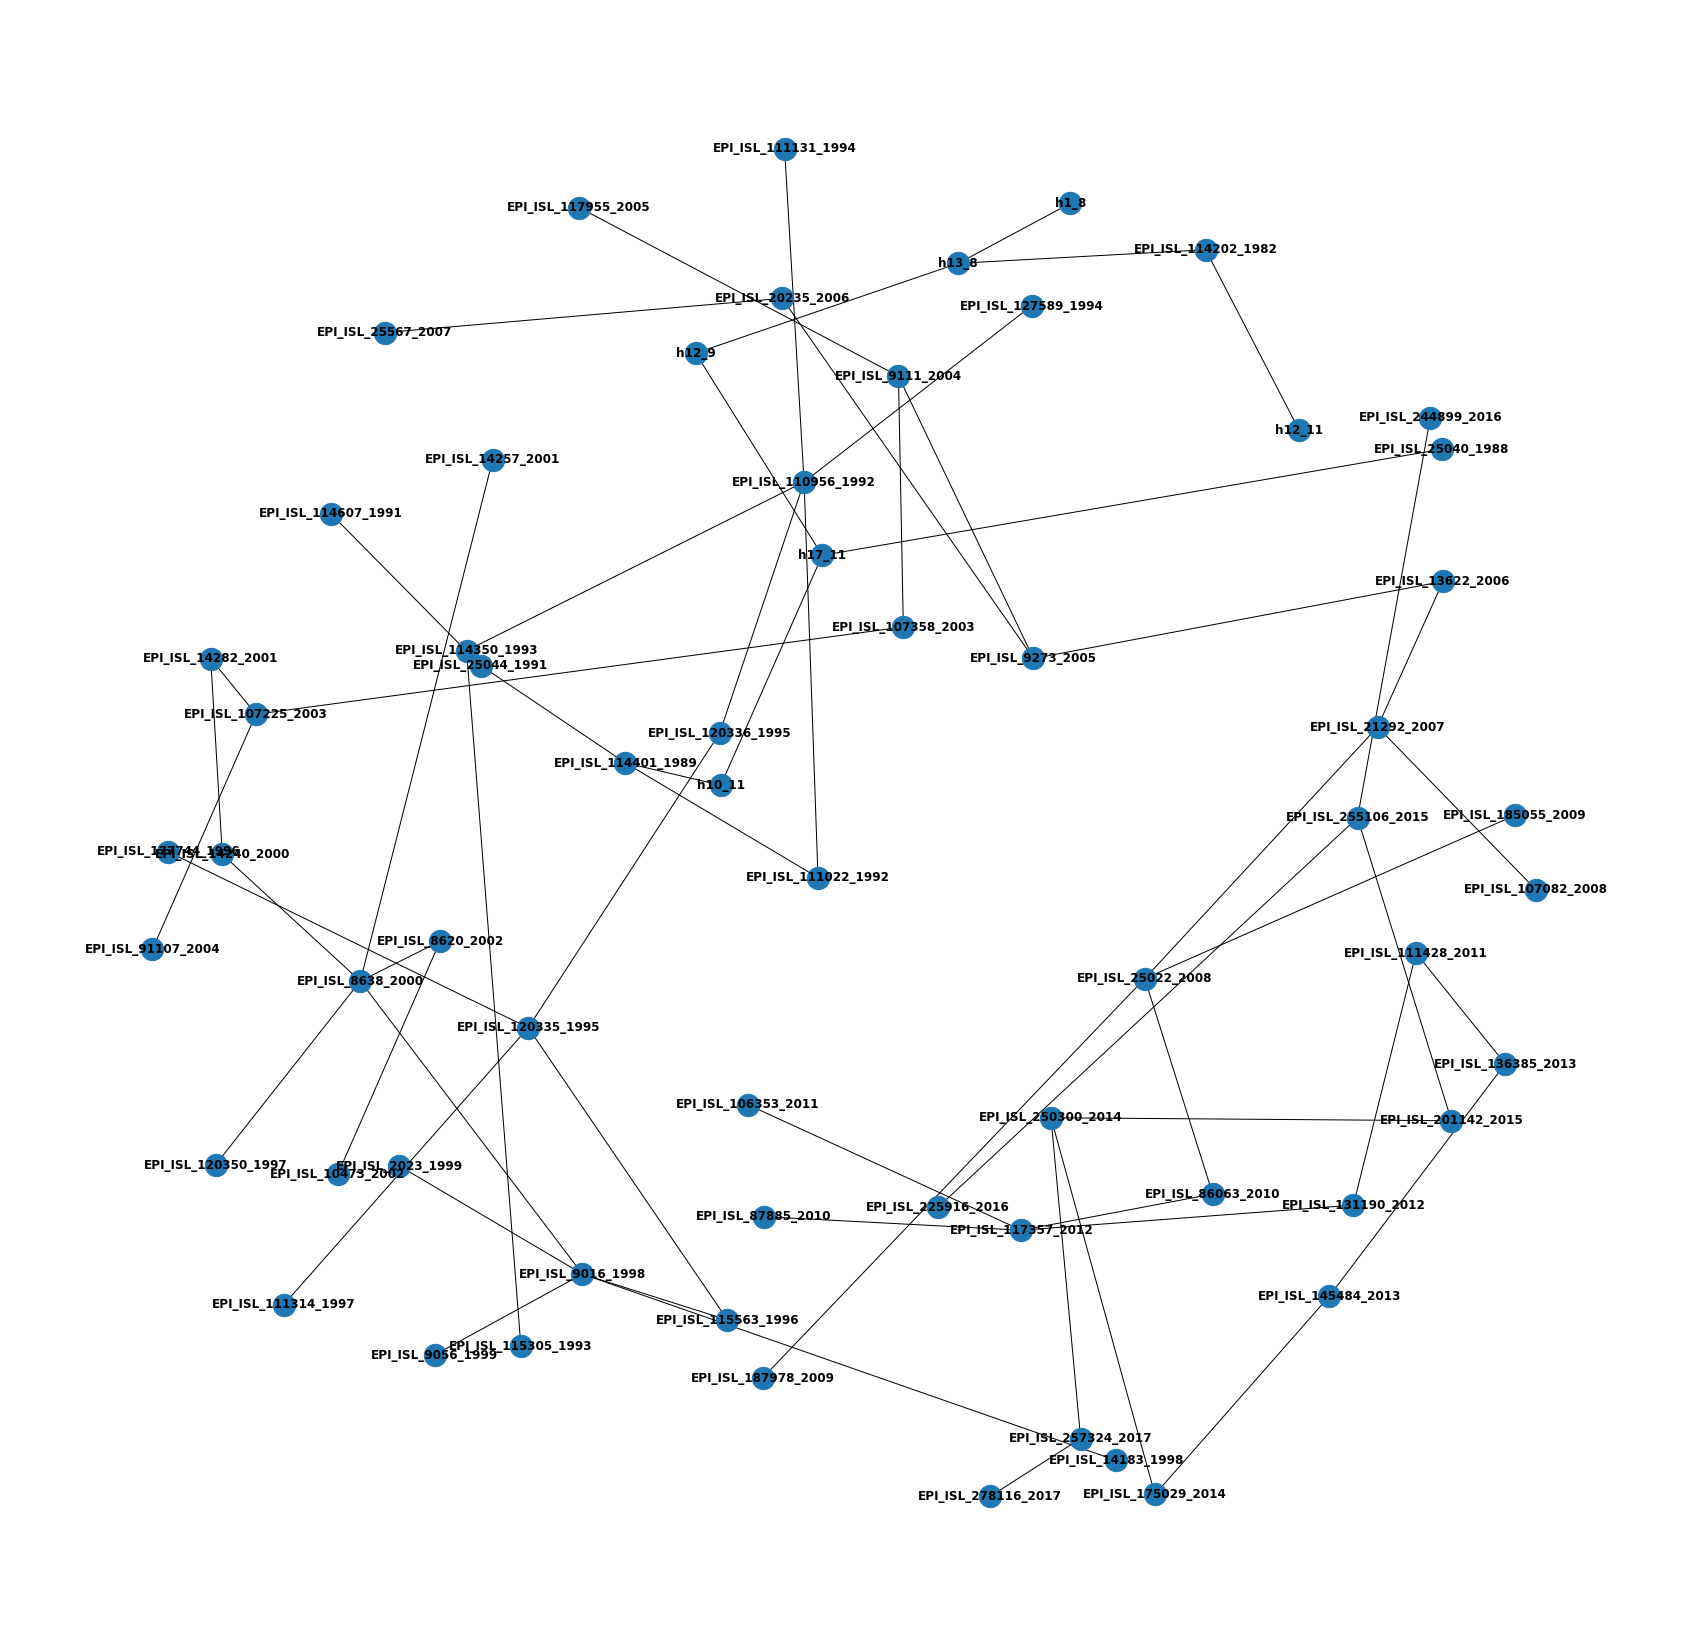

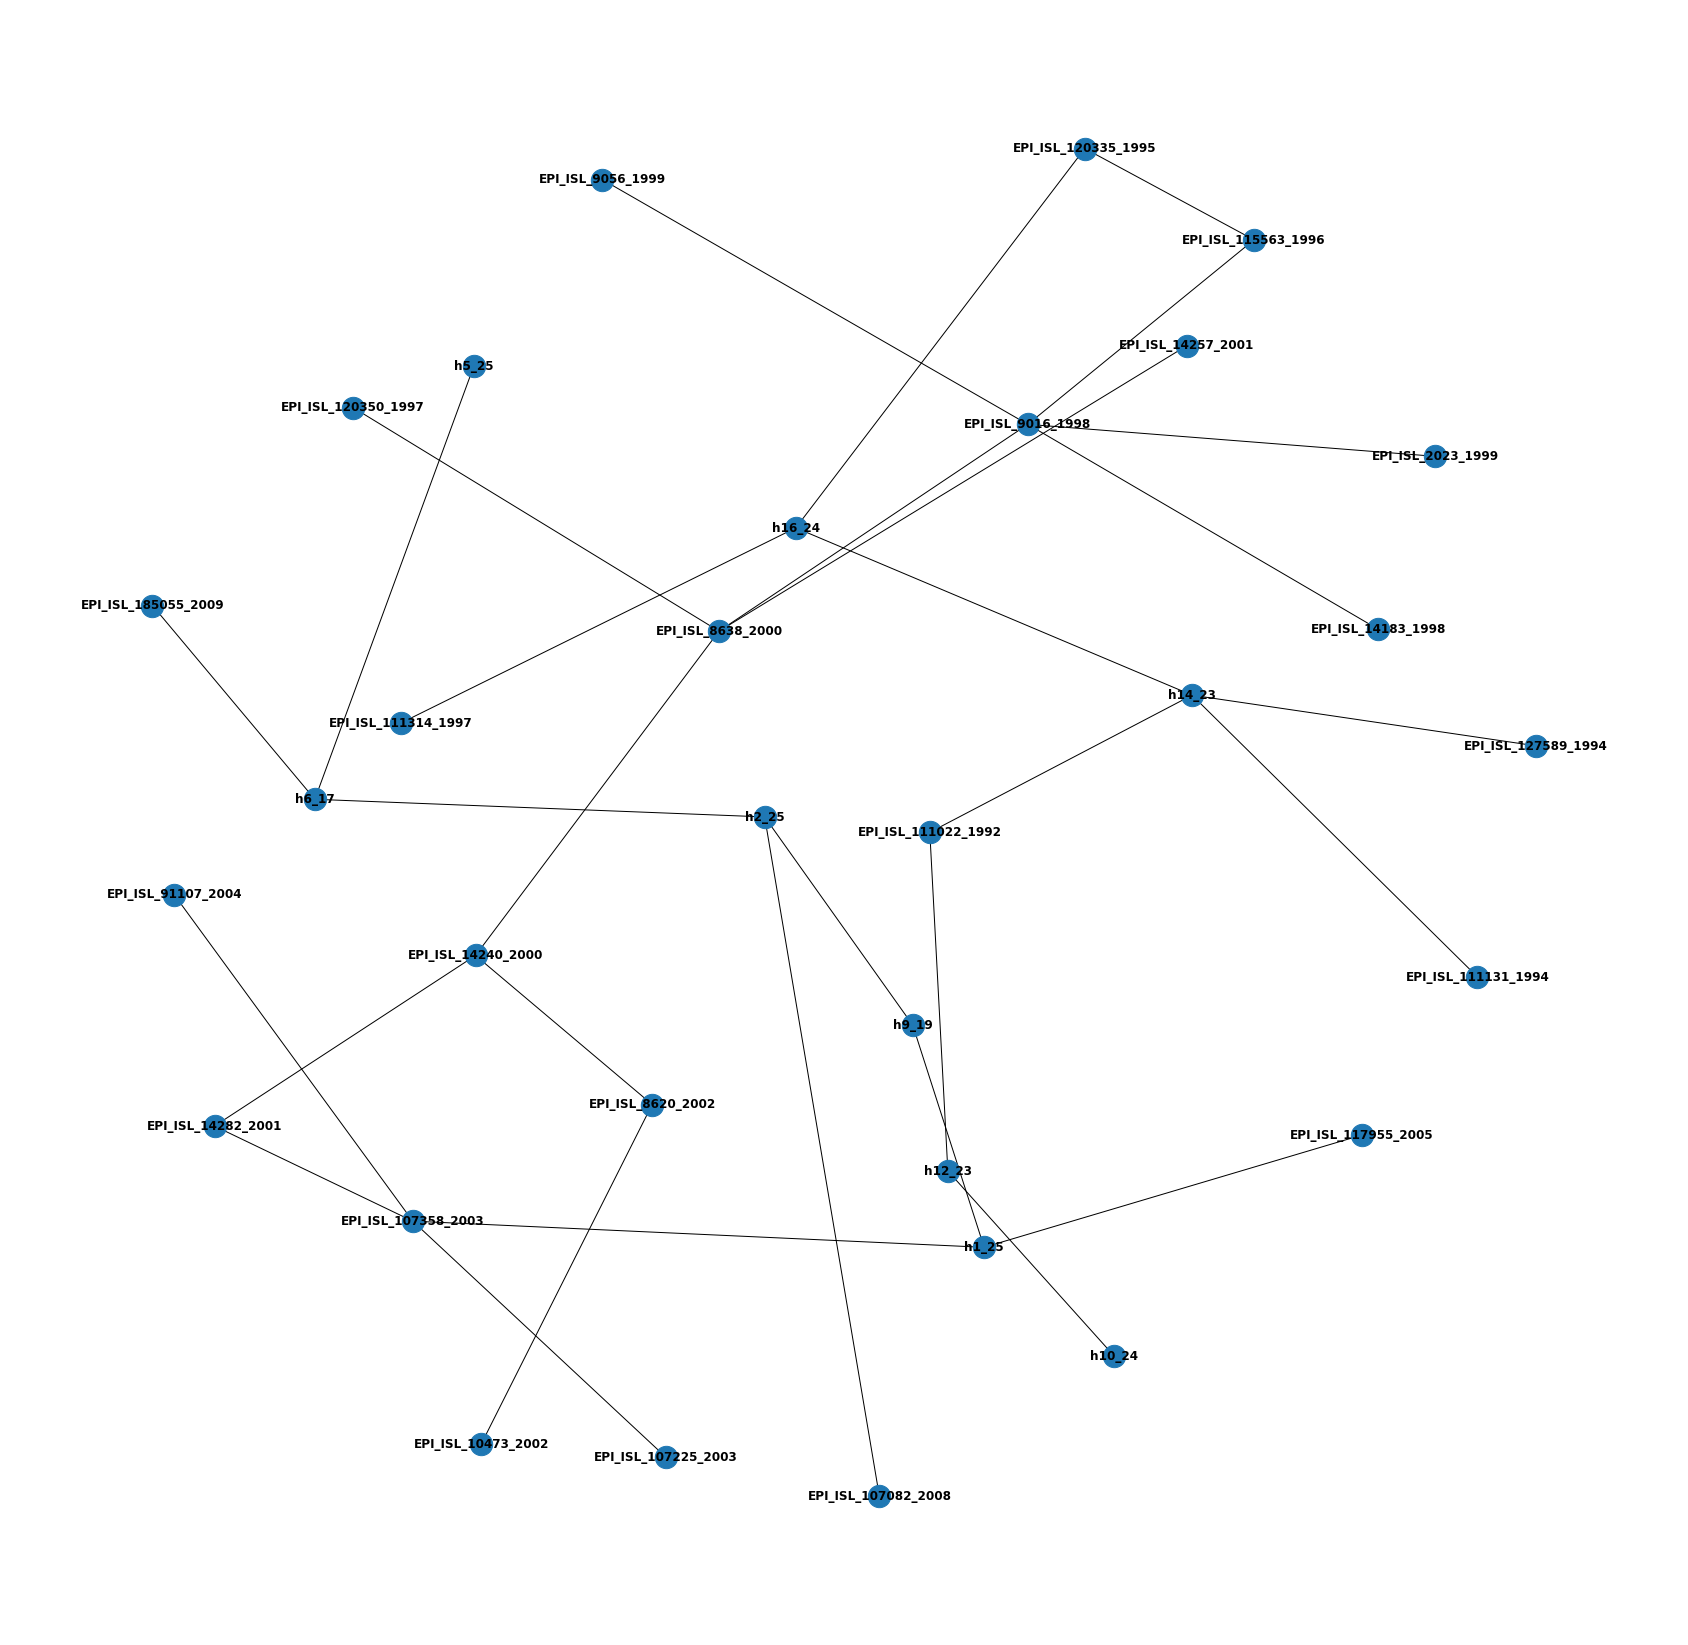

In [30]:
#Record the starting time
start_time = time.time()

#Read the sequences
sequences = {}
jc_distances = {}

fasta_file = open(fasta_file_path,'r')
seq = ''
seq_id = ''
for line in fasta_file:
  if line.startswith('>'):
    seq_id = line.strip().split('>')[1]
    seq = ''
  else:
    seq += line.strip()
  if seq != '' and seq_id != '':
    sequences[seq_id] = seq

#Create the pairwise distance matrix
dist_mat = create_distance_matrix(sequences)

#Create the networkx-based MST
MST = create_mst_from_dist_mat(sequences, dist_mat)

fig, ax = plt.subplots(figsize=(30, 30))
nx.draw(MST, with_labels=True, font_weight='bold', node_size = 500)
mst_fn = fn + '.MST_starting.png'
fig.savefig(mst_fn)

#Create an unrooted global phylogeny tree
T_global = Tree("global")
T_global.Read_fasta_file(fasta_file_path)


T_global = infer_global_tree(T_global, MST, sequences, W, threshold)
print("Elapsed time: %s seconds" % (time.time() - start_time))

stat_fn = fn + '.stats.csv'
df.to_csv(stat_fn, encoding='utf-8', index=False)

seq_df = pd.DataFrame(columns=['Name', "Sequence"])
i = 1
for v_name, v in T_global.vertex_map.items():
  seq_df.loc[i] = [v_name, v.sequence]
  i += 1

seq_fn = fn + '.global_tree_sequences.csv'
seq_df.to_csv(seq_fn, encoding='utf-8', index=False)

newick = newick_global_tree(T_global)
print(newick)